In [25]:
# Core data handling and analysis
import pandas as pd
import numpy as np
import yfinance as yf
import ta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("darkgrid")  # Use seaborn's style directly
plt.rcParams['figure.figsize'] = (12, 6)

# AAPL Stock Price Prediction with Technical Indicators

This notebook performs a comprehensive analysis of AAPL stock data with the following steps:

1. **Data Collection**: Download 5-minute intraday data using yfinance
2. **Technical Analysis**: Calculate various technical indicators using the ta library
3. **Feature Selection**: Select the most relevant indicators for prediction
4. **Data Preprocessing**: Handle missing values and outliers
5. **Target Creation**: Prepare the data for price prediction

Each step is documented in detail with explanations and visualizations.

In [26]:
# Download historical stock data for Apple (60 days, 5-minute intervals)
print("Downloading AAPL data...")
df = yf.download("AAPL", period="60d", interval="5m")

# Flatten MultiIndex columns if they exist
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] if col[0] != "Datetime" else col[0] for col in df.columns]

# Reset index to make Datetime a column
df.reset_index(inplace=True)

# Ensure numeric types for OHLCV columns
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nData shape:", df.shape)
print("\nFirst few rows:")
display(df.head())

/tmp/ipykernel_14469/3547943188.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", period="60d", interval="5m")
[*********************100%***********************]  1 of 1 completed


Data shape: (4680, 6)

First few rows:


,Datetime,Close,High,Low,Open,Volume
0,2025-08-08 13:30:00+00:00,219.809998,221.009995,219.250000,220.429993,2923939
1,2025-08-08 13:35:00+00:00,219.794495,219.975006,219.389999,219.819901,1169805
2,2025-08-08 13:40:00+00:00,220.384995,220.524994,219.698593,219.797607,1069394
3,2025-08-08 13:45:00+00:00,220.565002,221.000000,220.339005,220.582108,894972
4,2025-08-08 13:50:00+00:00,220.929794,220.990005,220.380005,220.574997,645938


# Detailed Technical Indicator Calculations

We'll calculate technical indicators in groups:
1. Trend Indicators (moving averages, MACD)
2. Momentum Indicators (RSI, Stochastic)
3. Volatility Indicators (Bollinger Bands, ATR)
4. Volume Indicators (OBV, VWAP)

In [27]:
# Initialize an empty DataFrame with our OHLCV data
df_tech = df.copy()

# 1. Trend Indicators
print("Calculating Trend Indicators...")

# Moving Averages
df_tech['trend_sma_fast'] = ta.trend.sma_indicator(df_tech['Close'], window=10)
df_tech['trend_sma_slow'] = ta.trend.sma_indicator(df_tech['Close'], window=20)
df_tech['trend_ema_fast'] = ta.trend.ema_indicator(df_tech['Close'], window=10)
df_tech['trend_ema_slow'] = ta.trend.ema_indicator(df_tech['Close'], window=20)

# MACD
macd = ta.trend.MACD(df_tech['Close'])
df_tech['trend_macd'] = macd.macd()
df_tech['trend_macd_signal'] = macd.macd_signal()
df_tech['trend_macd_diff'] = macd.macd_diff()

# ADX
df_tech['trend_adx'] = ta.trend.ADXIndicator(df_tech['High'], df_tech['Low'], df_tech['Close']).adx()

print("Trend indicators calculated!")

Calculating Trend Indicators...
Trend indicators calculated!


In [28]:
# Load your reduced dataset
fn = "AAPL_60d_5min_reduced.csv"
df = pd.read_csv(fn)

# Convert Datetime if it exists and set as index
if "Datetime" in df.columns:
    df["Datetime"] = pd.to_datetime(df["Datetime"])
    df.set_index("Datetime", inplace=True)

# Inspect first rows and data types
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4578 entries, 0 to 4577
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  4578 non-null   float64
 1   High                  4578 non-null   float64
 2   Low                   4578 non-null   float64
 3   Close                 4578 non-null   float64
 4   Volume                4578 non-null   int64  
 5   trend_sma_fast        4578 non-null   float64
 6   trend_sma_slow        4578 non-null   float64
 7   trend_ema_fast        4578 non-null   float64
 8   trend_ema_slow        4578 non-null   float64
 9   trend_macd_diff       4578 non-null   float64
 10  trend_adx             4578 non-null   float64
 11  momentum_rsi          4578 non-null   float64
 12  momentum_stoch_rsi_k  4578 non-null   float64
 13  momentum_stoch_rsi_d  4578 non-null   float64
 14  momentum_roc          4578 non-null   float64
 15  volatility_atr       

In [29]:
# 1. Drop initial rows with 0.0s from indicator lookback
# (Assuming a max lookback of 50 periods. Adjust if needed.)
df_processed = df.iloc[50:].copy()

# 2. Handle outliers (Log transform 'Volume')
df_processed['Volume'] = np.log1p(df_processed['Volume'])

# 3. Define the *correct* feature set (X)
# We drop all target-related and non-predictive columns
features_to_drop = ['Open', 'High', 'Low', 'Close', 'index']
features = [col for col in df_processed.columns if col not in features_to_drop]

# Create X (using all data *before* target creation)
X = df_processed[features].copy()

# 4. Create the target variable (y)
y = df_processed['Close'].shift(-2)

# Now, we must drop the last 2 rows from BOTH X and y, as they have no target
X = X.iloc[:-2]
y = y.iloc[:-2]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print("\nFeatures being used:")
print(X.columns.tolist())

Shape of X: (4526, 16)
Shape of y: (4526,)

Features being used:
['Volume', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_macd_diff', 'trend_adx', 'momentum_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_roc', 'volatility_atr', 'volatility_bbw', 'volume_obv', 'volume_vwap', 'volume_mfi']


In [30]:
# Split the data into training and test sets
# IMPORTANT: shuffle=False is critical for time-series data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=False
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3620, 16)
X_test shape: (906, 16)
y_train shape: (3620,)
y_test shape: (906,)


In [31]:
# 1. Initialize Scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 2. Fit and transform the TRAINING data
# Note: y_train must be reshaped for the scaler
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# 3. ONLY transform the TEST data
# We use the scaler that was 'fit' on the training data
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print("Scaling complete. Scalers are fit and ready for deployment.")

Scaling complete. Scalers are fit and ready for deployment.


In [32]:
# 1. Define models and parameter grids
models_to_tune = {
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [0.1, 1.0, 10.0, 50.0, 100.0]}
    },
    'Lasso': {
        'model': Lasso(max_iter=10000),
        'params': {'alpha': [0.0001, 0.001, 0.01, 0.1]}
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 10, 20]
        }
    }
}

# 2. Set up TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# 3. Run Grid Search
best_models = {}
for name, info in models_to_tune.items():
    print(f"Tuning {name}...")
    gs = GridSearchCV(
        estimator=info['model'],
        param_grid=info['params'],
        cv=tscv,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )
    
    # Fit on the *scaled* training data
    gs.fit(X_train_scaled, y_train_scaled.ravel()) # .ravel() to match shape
    
    print(f"Best parameters for {name}: {gs.best_params_}")
    print(f"Best CV MSE for {name}: {-gs.best_score_:.4f}")
    
    best_models[name] = gs.best_estimator_

Tuning Ridge...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Ridge: {'alpha': 0.1}
Best CV MSE for Ridge: 0.0034
Tuning Lasso...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Lasso: {'alpha': 0.0001}
Best CV MSE for Lasso: 0.0034
Tuning DecisionTree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Lasso: {'alpha': 0.0001}
Best CV MSE for Lasso: 0.0034
Tuning DecisionTree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for DecisionTree: {'max_depth': None, 'min_samples_split': 10}
Best CV MSE for DecisionTree: 0.1704
Best parameters for DecisionTree: {'max_depth': None, 'min_samples_split': 10}
Best CV MSE for DecisionTree: 0.1704



--- Final Model Evaluation ---
Model: Ridge
Test Set MSE: 0.3561
Test Set R² Score: 0.9849


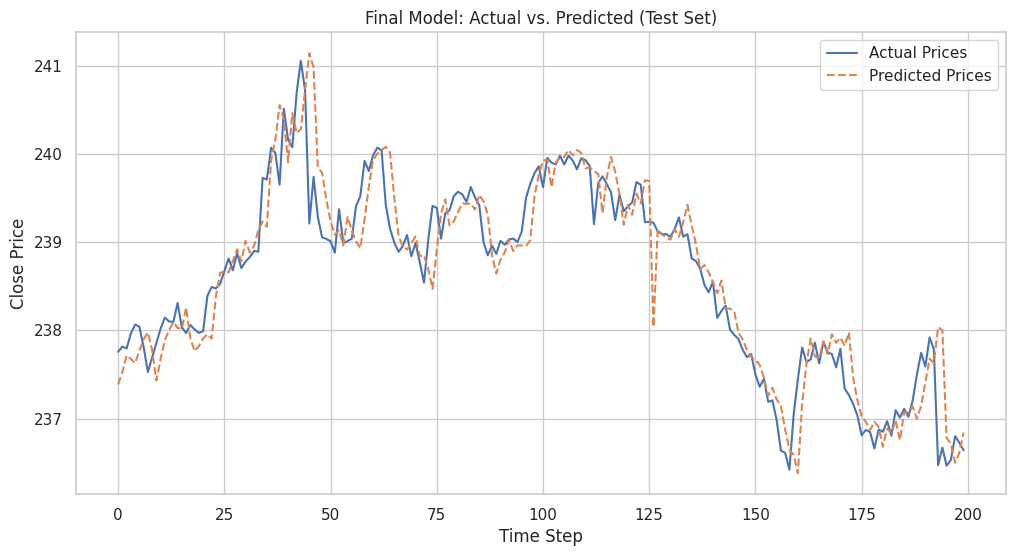

In [23]:
# Let's assume Ridge was our best model from CV
# (Replace 'Ridge' if another model performed better)
final_model = best_models['Ridge']

# 1. Predict on the scaled test set
y_pred_scaled = final_model.predict(X_test_scaled)

# 2. Inverse-transform predictions and actuals to get prices
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_scaled).flatten()

# 3. Calculate final metrics
final_mse = mean_squared_error(y_test_original, y_pred)
final_r2 = r2_score(y_test_original, y_pred)

print("\n--- Final Model Evaluation ---")
print(f"Model: {final_model.__class__.__name__}")
print(f"Test Set MSE: {final_mse:.4f}")
print(f"Test Set R² Score: {final_r2:.4f}")

# 4. Plot final results (first 200 points)
plt.plot(y_test_original[:200], label="Actual Prices")
plt.plot(y_pred[:200], label="Predicted Prices", linestyle="--")
plt.title("Final Model: Actual vs. Predicted (Test Set)")
plt.ylabel("Close Price")
plt.xlabel("Time Step")
plt.legend()
plt.show()


--- Final Model Evaluation ---
Model: Ridge
Test Set MSE: 0.3561
Test Set R² Score: 0.9849


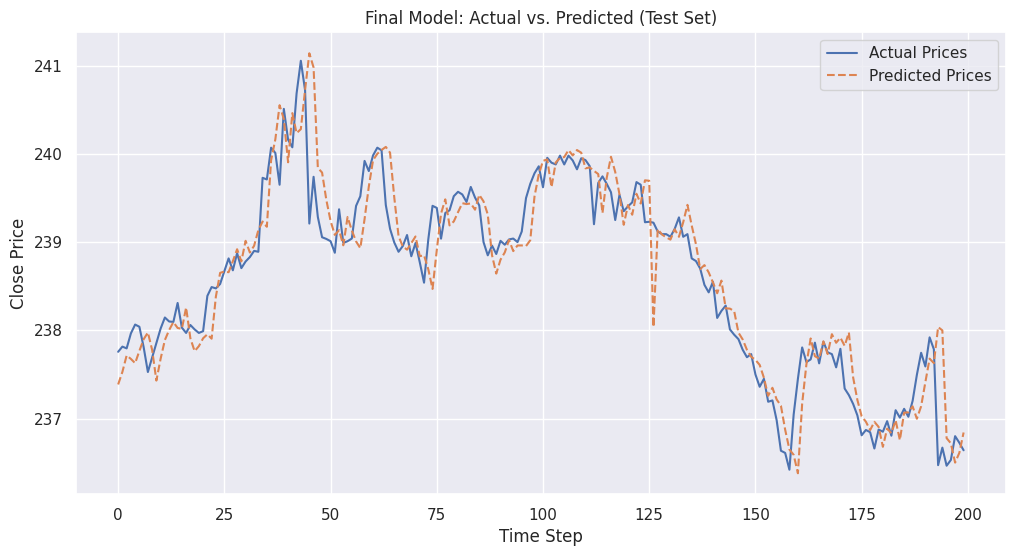

In [33]:
# Let's assume Ridge was our best model from CV
# (Replace 'Ridge' if another model performed better)
final_model = best_models['Ridge']

# 1. Predict on the scaled test set
y_pred_scaled = final_model.predict(X_test_scaled)

# 2. Inverse-transform predictions and actuals to get prices
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_scaled).flatten()

# 3. Calculate final metrics
final_mse = mean_squared_error(y_test_original, y_pred)
final_r2 = r2_score(y_test_original, y_pred)

print("\n--- Final Model Evaluation ---")
print(f"Model: {final_model.__class__.__name__}")
print(f"Test Set MSE: {final_mse:.4f}")
print(f"Test Set R² Score: {final_r2:.4f}")

# 4. Plot final results (first 200 points)
plt.plot(y_test_original[:200], label="Actual Prices")
plt.plot(y_pred[:200], label="Predicted Prices", linestyle="--")
plt.title("Final Model: Actual vs. Predicted (Test Set)")
plt.ylabel("Close Price")
plt.xlabel("Time Step")
plt.legend()
plt.show()

In [34]:
# 1. Define filenames
model_file = "stock_predictor_model.joblib"
scaler_X_file = "stock_scaler_X.joblib"
scaler_y_file = "stock_scaler_y.joblib"

# 2. Save the components
joblib.dump(final_model, model_file)
joblib.dump(scaler_X, scaler_X_file)
joblib.dump(scaler_y, scaler_y_file)

print(f"Model saved to: {model_file}")
print(f"X Scaler saved to: {scaler_X_file}")
print(f"y Scaler saved to: {scaler_y_file}")

Model saved to: stock_predictor_model.joblib
X Scaler saved to: stock_scaler_X.joblib
y Scaler saved to: stock_scaler_y.joblib


# Technical Indicators

We'll calculate and use the following key indicators:

## Trend Indicators
- SMA (Fast & Slow)
- EMA (Fast & Slow)
- MACD
- ADX

## Momentum Indicators
- RSI
- Stochastic RSI
- Rate of Change

## Volatility Indicators
- ATR
- Bollinger Bands Width

## Volume Indicators
- On-Balance Volume
- VWAP
- Money Flow Index

In [ ]:
# Calculate all technical indicators
print("Calculating technical indicators...")
df_indicators = ta.add_all_ta_features(
    df,
    open="Open",
    high="High",
    low="Low",
    close="Close",
    volume="Volume",
    fillna=True
)

# Select important indicators
important_columns = [
    "Open", "High", "Low", "Close", "Volume",
    "trend_sma_fast", "trend_sma_slow", "trend_ema_fast", "trend_ema_slow",
    "trend_macd_diff", "trend_adx",
    "momentum_rsi", "momentum_stoch_rsi_k", "momentum_stoch_rsi_d", "momentum_roc",
    "volatility_atr", "volatility_bbw",
    "volume_obv", "volume_vwap", "volume_mfi"
]

# Create reduced dataset with selected features
df_reduced = df_indicators[important_columns].copy()

# Save both full and reduced datasets
df_indicators.to_csv("AAPL_60d_5min_with_indicators.csv", index=False)
df_reduced.to_csv("AAPL_60d_5min_reduced.csv", index=False)

print("\nFeatures in reduced dataset:")
print(df_reduced.columns.tolist())
print("\nShape of reduced dataset:", df_reduced.shape)

In [ ]:
# Data quality checks
print("Checking for missing values:")
print(df_reduced.isna().sum())

# Drop any remaining NaNs and reset index
df_reduced = df_reduced.dropna().reset_index(drop=True)

# Basic statistics of the features
print("\nBasic statistics of the features:")
display(df_reduced.describe())

# Correlation heatmap of the main features
plt.figure(figsize=(15, 10))
sns.heatmap(df_reduced.corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
# 2. Momentum Indicators
print("\nCalculating Momentum Indicators...")

# RSI
df_tech['momentum_rsi'] = ta.momentum.RSIIndicator(df_tech['Close']).rsi()

# Stochastic RSI
stoch_rsi = ta.momentum.StochRSIIndicator(df_tech['Close'])
df_tech['momentum_stoch_rsi_k'] = stoch_rsi.stochrsi_k()
df_tech['momentum_stoch_rsi_d'] = stoch_rsi.stochrsi_d()

# ROC (Rate of Change)
df_tech['momentum_roc'] = ta.momentum.ROCIndicator(df_tech['Close']).roc()

print("Momentum indicators calculated!")

In [ ]:
# 3. Volatility Indicators
print("\nCalculating Volatility Indicators...")

# ATR (Average True Range)
df_tech['volatility_atr'] = ta.volatility.AverageTrueRange(
    df_tech['High'], df_tech['Low'], df_tech['Close']
).average_true_range()

# Bollinger Bands
bollinger = ta.volatility.BollingerBands(df_tech['Close'])
df_tech['volatility_bbm'] = bollinger.bollinger_mavg()
df_tech['volatility_bbh'] = bollinger.bollinger_hband()
df_tech['volatility_bbl'] = bollinger.bollinger_lband()
df_tech['volatility_bbw'] = bollinger.bollinger_wband()  # Width of the bands

print("Volatility indicators calculated!")

In [ ]:
# 4. Volume Indicators
print("\nCalculating Volume Indicators...")

# On Balance Volume
df_tech['volume_obv'] = ta.volume.on_balance_volume(df_tech['Close'], df_tech['Volume'])

# Volume Weighted Average Price (VWAP)
df_tech['volume_vwap'] = ta.volume.VolumeWeightedAveragePrice(
    high=df_tech['High'],
    low=df_tech['Low'],
    close=df_tech['Close'],
    volume=df_tech['Volume']
).volume_weighted_average_price()

# Money Flow Index
df_tech['volume_mfi'] = ta.volume.MFIIndicator(
    high=df_tech['High'],
    low=df_tech['Low'],
    close=df_tech['Close'],
    volume=df_tech['Volume']
).money_flow_index()

print("Volume indicators calculated!")

# Display the first few rows with all indicators
print("\nFirst few rows of data with technical indicators:")
display(df_tech.head())

In [ ]:
# Filter and select the important features
important_columns = [
    # Base OHLCV data
    "Open", "High", "Low", "Close", "Volume",
    
    # Trend indicators
    "trend_sma_fast", "trend_sma_slow", 
    "trend_ema_fast", "trend_ema_slow",
    "trend_macd_diff", "trend_adx",
    
    # Momentum indicators
    "momentum_rsi", "momentum_stoch_rsi_k", 
    "momentum_stoch_rsi_d", "momentum_roc",
    
    # Volatility indicators
    "volatility_atr", "volatility_bbw",
    
    # Volume indicators
    "volume_obv", "volume_vwap", "volume_mfi"
]

# Create the reduced dataset
df_reduced = df_tech[important_columns].copy()

# Save both datasets
df_tech.to_csv("AAPL_60d_5min_with_indicators.csv", index=False)
df_reduced.to_csv("AAPL_60d_5min_reduced.csv", index=False)

print("\nShape of full dataset:", df_tech.shape)
print("Shape of reduced dataset:", df_reduced.shape)
print("\nColumns in reduced dataset:", df_reduced.columns.tolist())

# 1. Data Collection

We'll download AAPL stock data:
- Timeframe: Last 60 days
- Interval: 5 minutes
- Data: OHLCV (Open, High, Low, Close, Volume)

In [ ]:
# Download historical stock data for Apple
print("Downloading AAPL data (60 days, 5-minute intervals)...")
df = yf.download("AAPL", period="60d", interval="5m")

# Flatten MultiIndex columns if they exist
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] if col[0] != "Datetime" else col[0] for col in df.columns]

# Reset index to make Datetime a column
df.reset_index(inplace=True)

# Convert OHLCV columns to numeric
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nDataset Shape:", df.shape)
print("\nFirst few rows:")
display(df.head())

print("\nData Types:")
print(df.dtypes)

# 2. Technical Indicators

We calculate a comprehensive set of technical indicators using the `ta` library. These indicators help the model understand:
- Trend patterns
- Momentum signals
- Volatility levels
- Volume patterns

See the detailed explanation of each indicator below.

In [ ]:
# Calculate all technical indicators
print("Calculating technical indicators...")
df = ta.add_all_ta_features(
    df,
    open="Open",
    high="High",
    low="Low",
    close="Close",
    volume="Volume",
    fillna=True  # fills NaNs without dropping rows
)

# Save full dataset with all indicators
df.to_csv("AAPL_60d_5min_with_indicators.csv", index=False)

print("\nDataset shape after adding indicators:", df.shape)
print("\nAll available indicators:")
print(df.columns.tolist())

# Selected Indicators for Intraday Price Prediction

For our intraday price prediction model, we are using a reduced set of important indicators derived from OHLCV data. These indicators help the model understand **trend, momentum, volatility, and volume patterns** in the market.

## 1. Base Data (OHLCV)
- **Open**: Price at the start of the time interval
- **High**: Highest price during the interval
- **Low**: Lowest price during the interval
- **Close**: Price at the end of the interval
- **Volume**: Number of shares traded during the interval

## 2. Trend Indicators
- **trend_sma_fast**: Fast Simple Moving Average. Captures short-term trend
- **trend_sma_slow**: Slow Simple Moving Average. Shows long-term trend
- **trend_ema_fast**: Fast Exponential Moving Average. Gives more weight to recent prices
- **trend_ema_slow**: Slow Exponential Moving Average. Smoother long-term trend detection
- **trend_macd_diff**: MACD difference. Shows momentum and potential reversals
- **trend_adx**: Average Directional Index (0-100). Measures trend strength

## 3. Momentum Indicators
- **momentum_rsi**: Relative Strength Index (0-100). Shows overbought/oversold conditions
- **momentum_stoch_rsi_k**: Fast %K of Stochastic RSI. Sensitive momentum indicator
- **momentum_stoch_rsi_d**: Smoothed %D of Stochastic RSI. Reduces noise
- **momentum_roc**: Rate of Change. Shows price change percentage

## 4. Volatility Indicators
- **volatility_atr**: Average True Range. Measures market volatility
- **volatility_bbw**: Bollinger Band Width. Shows volatility expansion/contraction

## 5. Volume Indicators
- **volume_obv**: On-Balance Volume. Shows buying/selling pressure
- **volume_vwap**: Volume Weighted Average Price. Price benchmark
- **volume_mfi**: Money Flow Index. Volume-weighted RSI

In [ ]:
# Select important columns for our model
important_columns = [
    # Base OHLCV data
    "Open", "High", "Low", "Close", "Volume",
    
    # Trend indicators
    "trend_sma_fast", "trend_sma_slow", 
    "trend_ema_fast", "trend_ema_slow",
    "trend_macd_diff", "trend_adx",
    
    # Momentum indicators
    "momentum_rsi", "momentum_stoch_rsi_k", 
    "momentum_stoch_rsi_d", "momentum_roc",
    
    # Volatility indicators
    "volatility_atr", "volatility_bbw",
    
    # Volume indicators
    "volume_obv", "volume_vwap", "volume_mfi"
]

# Create reduced dataset
df_reduced = df[important_columns].copy()

# Save reduced dataset
df_reduced.to_csv("AAPL_60d_5min_reduced.csv", index=False)

print("Reduced dataset saved! Shape:", df_reduced.shape)
print("\nColumns included:")
print(df_reduced.columns.tolist())

# 3. Data Quality Analysis

Let's analyze our reduced dataset for:
1. Missing values
2. Basic statistics
3. Outliers in key features
4. Unusual patterns

In [ ]:
# Check for missing values
miss = df_reduced.isna().sum()
miss_pct = (miss / len(df_reduced) * 100).round(3)
missing_table = pd.concat([miss, miss_pct], axis=1, keys=["n_missing","pct_missing"])

print("Missing Value Analysis:")
display(missing_table)

# Basic statistics
print("\nBasic Statistics:")
display(df_reduced.describe().T)

# Clean any remaining NaNs if present
df_reduced = df_reduced.dropna().reset_index(drop=True)
print("\nShape after cleaning:", df_reduced.shape)

# Outlier Analysis

We'll analyze potential outliers in key features:
- Volume (often has significant spikes)
- momentum_roc (Rate of Change can have extremes)
- volatility_bbw (Bollinger Band Width during volatile periods)

Note: In financial time series, "outliers" are often real events (earnings announcements, market crashes, high-volume days). We should analyze them carefully rather than removing them blindly.

In [ ]:
# Analyze potential outliers in key features
suspect_cols = ["Volume", "momentum_roc", "volatility_bbw"]

# Create boxplots
df_reduced[suspect_cols].plot(
    kind="box",
    subplots=True,
    layout=(1, len(suspect_cols)),
    figsize=(15, 5),
    sharey=False
)
plt.suptitle("Outlier Check - Suspect Features", fontsize=14)
plt.tight_layout()
plt.show()

# Print summary statistics for these columns
print("\nSummary statistics for suspect columns:")
display(df_reduced[suspect_cols].describe())

# 4. Target Creation

For our prediction task, we'll create a target variable that represents the price 10 minutes into the future:
- Using 5-minute intervals
- Shift by 2 periods (2 * 5 = 10 minutes)
- Drop rows where target is NA (last 2 rows)

In [ ]:
# Create target variable (10-minute ahead price)
df_reduced['target_close'] = df_reduced['Close'].shift(-2)  # 2 periods * 5 minutes = 10 minutes

# Drop last 2 rows (they'll have NaN in target)
df_reduced = df_reduced.dropna().reset_index(drop=True)

print("Final dataset shape:", df_reduced.shape)
print("\nFirst 10 rows of Close price and target:")
display(df_reduced[['Close', 'target_close']].head(10))